<a href="https://www.kaggle.com/code/aayush2005/refined-india-rainfall-crop-production-ipynb?scriptVersionId=290053326" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn import preprocessing
import matplotlib.pyplot as plt
%matplotlib inline

import joblib

from sklearn.preprocessing import OneHotEncoder, StandardScaler, LabelEncoder
from sklearn.metrics import mean_absolute_error, r2_score, root_mean_squared_error
from xgboost import XGBRegressor

import scipy.stats as stats
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, mean_squared_error
from sklearn.model_selection import cross_val_predict

from sklearn.linear_model import LinearRegression, ElasticNet
from sklearn.tree import DecisionTreeClassifier

from sklearn.preprocessing import FunctionTransformer, PowerTransformer
from sklearn.compose import ColumnTransformer

from sklearn.model_selection import cross_val_score
from sklearn.pipeline import make_pipeline

from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error

from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform, randint

import os

# Step 1: Data Pre-Processing

## Loading of the dataset 

In [2]:
df = pd.read_csv(
    "/kaggle/input/refined-india-rainfall-and-crop-production-dataset/yeild_data.csv"
)

df.head()

,State_Name,Crop_Year,Season,Crop,Area,Production,Yeild,Rainfall
0,andaman and nicobar islands,2000,kharif,Arecanut,1254.0,2000.0,1.594896,1244.2
1,andaman and nicobar islands,2000,kharif,Rice,102.0,321.0,3.147059,1244.2
2,andaman and nicobar islands,2000,whole year,Banana,176.0,641.0,3.642045,2763.2
3,andaman and nicobar islands,2000,whole year,Cashewnut,720.0,165.0,0.229167,2763.2
4,andaman and nicobar islands,2000,whole year,Coconut,18168.0,65100000.0,3583.223250,2763.2


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 231609 entries, 0 to 231608
Data columns (total 8 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   State_Name  231609 non-null  object 
 1   Crop_Year   231609 non-null  int64  
 2   Season      231609 non-null  object 
 3   Crop        231609 non-null  object 
 4   Area        231609 non-null  float64
 5   Production  231609 non-null  float64
 6   Yeild       231609 non-null  float64
 7   Rainfall    231609 non-null  float64
dtypes: float64(4), int64(1), object(3)
memory usage: 14.1+ MB


In [4]:
df.describe()

,Crop_Year,Area,Production,Yeild,Rainfall
count,231609.000000,2.316090e+05,2.316090e+05,231609.000000,231609.000000
mean,2005.660402,1.217855e+04,6.073611e+05,40.668370,719.952237
std,4.962559,3.856970e+04,1.745646e+07,814.676381,688.613306
min,1997.000000,1.000000e-01,0.000000e+00,0.000000,0.000000
25%,2002.000000,8.800000e+01,9.400000e+01,0.531915,102.100000
50%,2006.000000,6.200000e+02,7.960000e+02,1.000000,537.150000
75%,2010.000000,4.757810e+03,7.632000e+03,2.467294,1148.300000
max,2015.000000,1.020181e+06,1.250800e+09,88000.000000,3825.200000


In [5]:
df.shape

(231609, 8)

## Stastical analysis of Data Preprocessing 
* involves examining the distribution, scale, and variability of features to select appropriate transformations that improve model learning. By understanding skewness, spread, and normalization effects before modeling, preprocessing steps can be applied in a data-driven and reproducible manner, leading to more stable and generalizable predictions. 

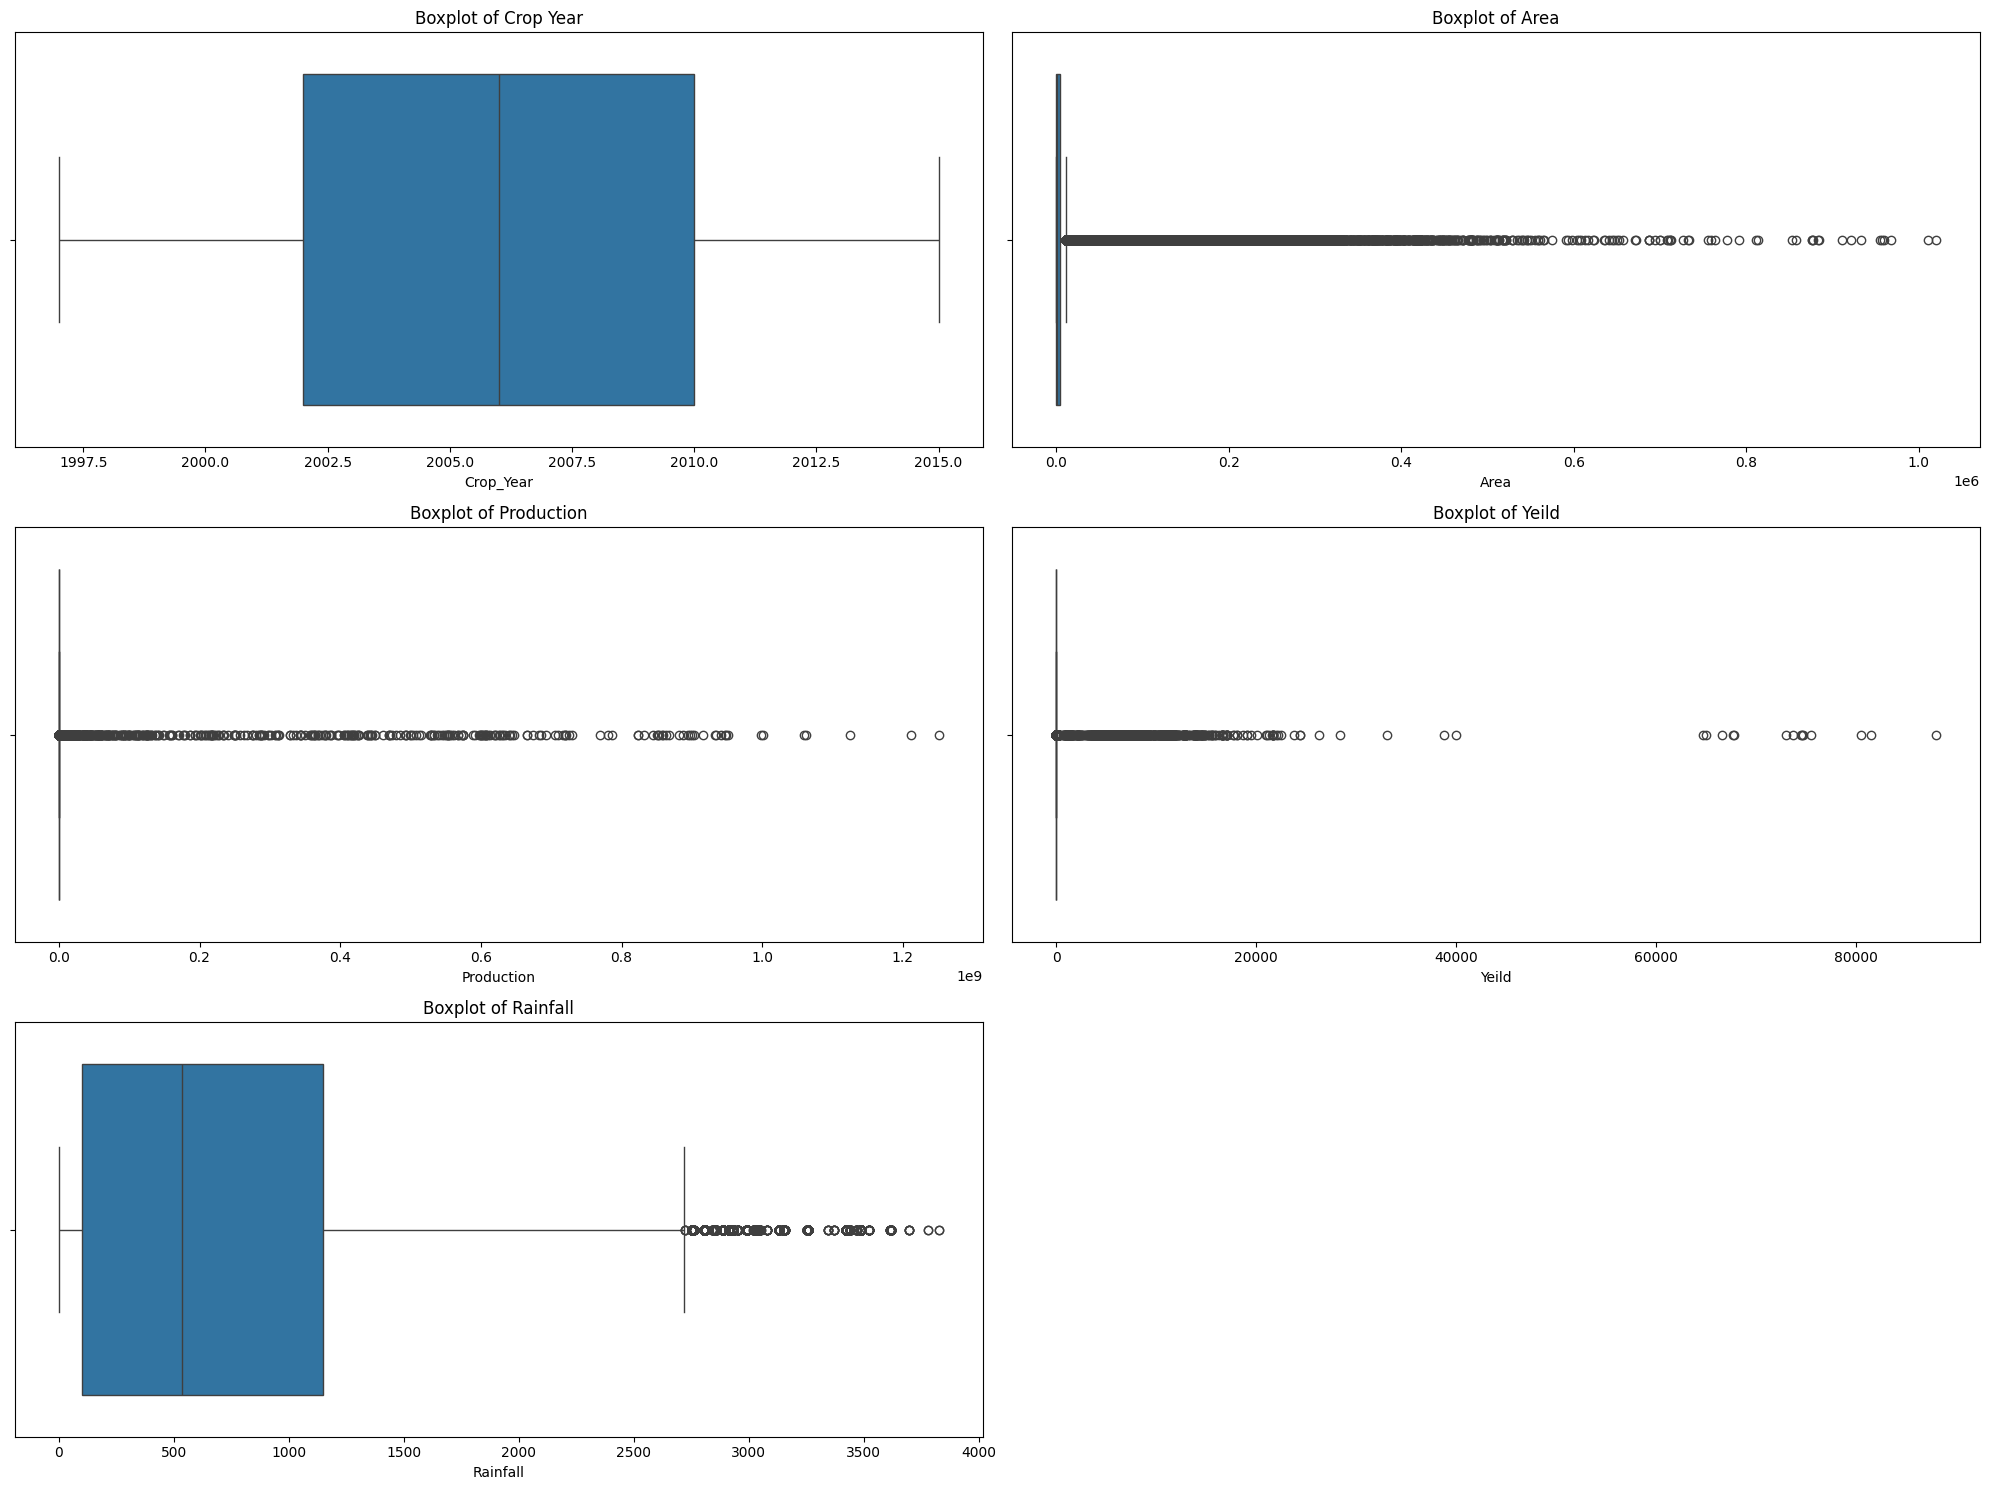

In [6]:

fig, axs = plt.subplots(3, 2, figsize=(20, 15)) 


sns.boxplot(x=df['Crop_Year'], ax=axs[0, 0])
axs[0, 0].set_title('Boxplot of Crop Year')

sns.boxplot(x=df['Area'], ax=axs[0, 1])
axs[0, 1].set_title('Boxplot of Area')



sns.boxplot(x=df['Production'], ax=axs[1, 0])
axs[1, 0].set_title('Boxplot of Production')


sns.boxplot(x=df['Yeild'], ax=axs[1, 1])
axs[1, 1].set_title('Boxplot of Yeild')



sns.boxplot(x=df['Rainfall'], ax=axs[2, 0])
axs[2, 0].set_title('Boxplot of Rainfall')


fig.delaxes(axs[2, 1])

plt.tight_layout()
plt.show()

**Observation:** As we can see that there are many 0 values for production which is an issue as production cant be with 0 values as the dataset from where its been taken and created says that the data is of crop production.

In [7]:
df[df['Production']==0.0] #seeing the rows for production with values 0.0.

,State_Name,Crop_Year,Season,Crop,Area,Production,Yeild,Rainfall
375,andhra pradesh,2002,kharif,Soyabean,51.0,0.0,0.0,358.30
402,andhra pradesh,2002,whole year,Cucumber,18.0,0.0,0.0,659.20
454,andhra pradesh,2003,whole year,Cucumber,51.0,0.0,0.0,911.15
1146,andhra pradesh,2002,whole year,Cabbage,4.0,0.0,0.0,659.20
1151,andhra pradesh,2002,whole year,Cucumber,8.0,0.0,0.0,659.20
...,...,...,...,...,...,...,...,...
207975,uttar pradesh,2003,rabi,Linseed,1.0,0.0,0.0,16.00
209270,uttar pradesh,2002,kharif,Moong(Green Gram),1.0,0.0,0.0,560.05
211061,uttar pradesh,2002,kharif,Moong(Green Gram),1.0,0.0,0.0,560.05
213907,uttar pradesh,2003,rabi,Linseed,1.0,0.0,0.0,16.00


In [8]:
df = df[df['Production'] != 0.0]

**Observation 2:** here in the above step we have removed the row for which the prodcution was 0.0 and the totla amount of rows is to be 2803 which is somewhat 1% of the data and trimming this wouldnt make any complications.

<Axes: xlabel='Production'>

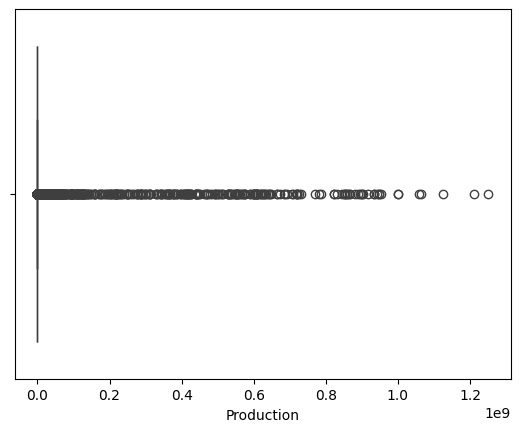

In [9]:
sns.boxplot(x=df['Production'])

In [10]:
(df['Production'] == 0.0).sum()

np.int64(0)

In [11]:
df['Production'].describe()

count    2.288060e+05
mean     6.148016e+05
std      1.756293e+07
min      1.000000e-02
25%      1.000000e+02
50%      8.300000e+02
75%      7.903750e+03
max      1.250800e+09
Name: Production, dtype: float64

In [12]:
df['State_Name'].nunique()

31

In [13]:
df['Crop'].nunique()

94

In [14]:
df['Season'].nunique()

6

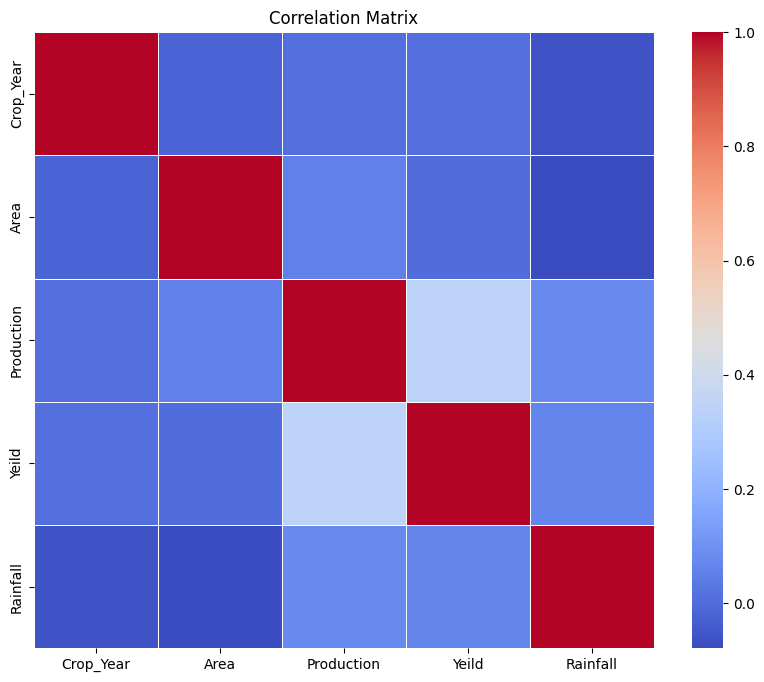

In [15]:
import seaborn as sns
import matplotlib.pyplot as plt

corr_matrix = df.corr(numeric_only=True)
corr_matrix

plt.figure(figsize=(10, 8))
sns.heatmap(
    corr_matrix,
    cmap="coolwarm",
    annot=False,
    fmt=".2f",
    linewidths=0.5
)
plt.title("Correlation Matrix")
plt.show()


In [16]:
df=pd.get_dummies(df, columns=['Season', 'State_Name'], drop_first=True)

## MEAN encoding(Target guided encoding)
-> It captures the relationship between the category and the target very directly. It turns a high-cardinality feature (lots of different crops) into a single numerical column, avoiding the "curse of dimensionality" you would get with One-Hot Encoding.

In [17]:
crop_means = df.groupby('Crop')['Production'].mean().to_dict()

In [18]:
crop_means

{'Arcanut (Processed)': 9641.55,
 'Arecanut': 13332.596107470512,
 'Arhar/Tur': 5284.490164000537,
 'Atcanut (Raw)': 46362.5,
 'Bajra': 24275.169599400975,
 'Banana': 47928.12594878529,
 'Barley': 5418.898214811183,
 'Bean': 312.0,
 'Beans & Mutter(Vegetable)': 2072.1470588235293,
 'Bhindi': 2710.059829059829,
 'Bitter Gourd': 35.3,
 'Black pepper': 2004.642033707865,
 'Blackgram': 443.82828282828285,
 'Bottle Gourd': 54.36363636363637,
 'Brinjal': 5737.952,
 'Cabbage': 3210.505154639175,
 'Cardamom': 487.90539772727277,
 'Carrot': 214.0,
 'Cashewnut': 2516.6620310981534,
 'Cashewnut Processed': 427.42105263157896,
 'Cashewnut Raw': 2813.2,
 'Castor seed': 4894.7709880331395,
 'Cauliflower': 1024.0555555555557,
 'Citrus Fruit': 4886.483333333334,
 'Coconut ': 68536421.4321999,
 'Coffee': 21668.666666666668,
 'Colocosia': 4530.909090909091,
 'Coriander': 1137.5629263859437,
 'Cotton(lint)': 68795.02564280751,
 'Cowpea(Lobia)': 441.5376146788991,
 'Drum Stick': 1329.6724137931035,
 'Dry 

In [19]:
df['Crop_Encoded'] = df['Crop'].map(crop_means)
df.head()

,Crop_Year,Crop,Area,Production,Yeild,Rainfall,Season_kharif,Season_rabi,Season_summer,Season_whole year,...,State_Name_punjab,State_Name_rajasthan,State_Name_sikkim,State_Name_tamil nadu,State_Name_telangana,State_Name_tripura,State_Name_uttar pradesh,State_Name_uttarakhand,State_Name_west bengal,Crop_Encoded
0,2000,Arecanut,1254.0,2000.0,1.594896,1244.2,True,False,False,False,...,False,False,False,False,False,False,False,False,False,1.333260e+04
1,2000,Rice,102.0,321.0,3.147059,1244.2,True,False,False,False,...,False,False,False,False,False,False,False,False,False,1.074007e+05
2,2000,Banana,176.0,641.0,3.642045,2763.2,False,False,False,True,...,False,False,False,False,False,False,False,False,False,4.792813e+04
3,2000,Cashewnut,720.0,165.0,0.229167,2763.2,False,False,False,True,...,False,False,False,False,False,False,False,False,False,2.516662e+03
4,2000,Coconut,18168.0,65100000.0,3583.223250,2763.2,False,False,False,True,...,False,False,False,False,False,False,False,False,False,6.853642e+07


In [20]:
df.drop('Crop', axis=1, inplace=True)

In [21]:
df.head()

,Crop_Year,Area,Production,Yeild,Rainfall,Season_kharif,Season_rabi,Season_summer,Season_whole year,Season_winter,...,State_Name_punjab,State_Name_rajasthan,State_Name_sikkim,State_Name_tamil nadu,State_Name_telangana,State_Name_tripura,State_Name_uttar pradesh,State_Name_uttarakhand,State_Name_west bengal,Crop_Encoded
0,2000,1254.0,2000.0,1.594896,1244.2,True,False,False,False,False,...,False,False,False,False,False,False,False,False,False,1.333260e+04
1,2000,102.0,321.0,3.147059,1244.2,True,False,False,False,False,...,False,False,False,False,False,False,False,False,False,1.074007e+05
2,2000,176.0,641.0,3.642045,2763.2,False,False,False,True,False,...,False,False,False,False,False,False,False,False,False,4.792813e+04
3,2000,720.0,165.0,0.229167,2763.2,False,False,False,True,False,...,False,False,False,False,False,False,False,False,False,2.516662e+03
4,2000,18168.0,65100000.0,3583.223250,2763.2,False,False,False,True,False,...,False,False,False,False,False,False,False,False,False,6.853642e+07


In [22]:
X=df.drop(columns=['Production', 'Yeild','Crop_Year'])
y=df['Yeild']

In [23]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

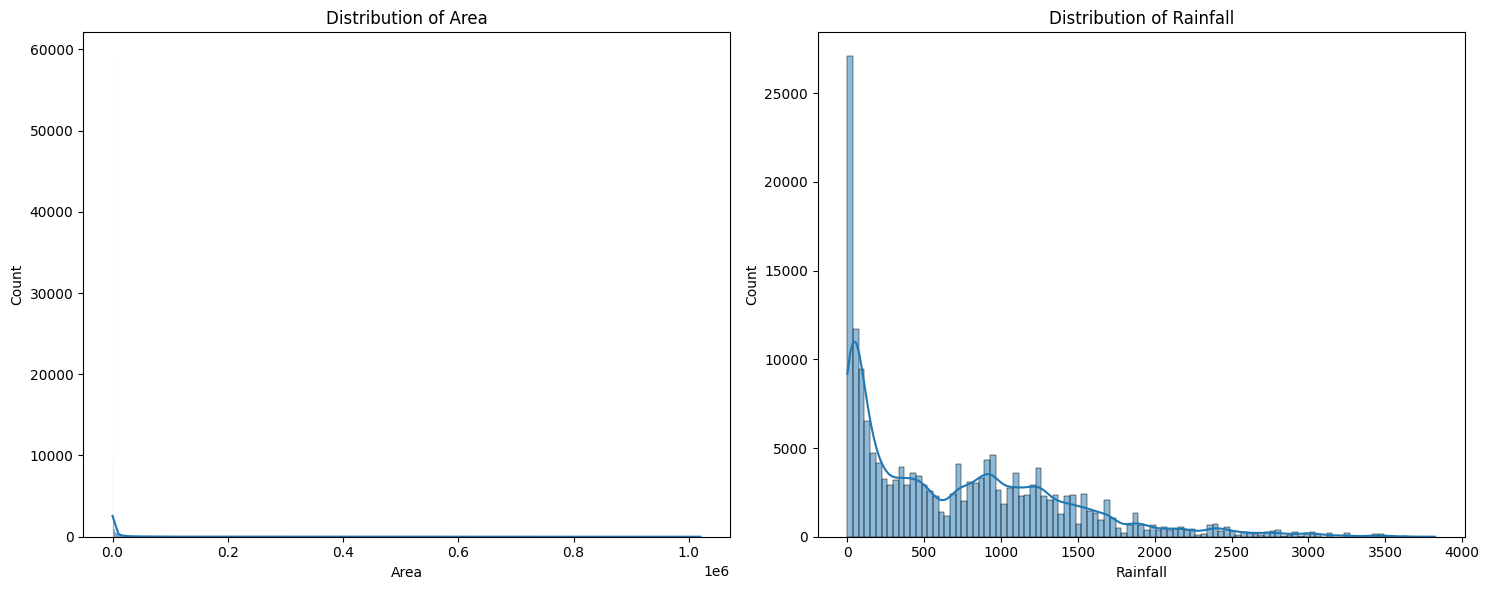

In [24]:

fig, axs = plt.subplots(1, 2, figsize=(15, 6))


sns.histplot(x=X_train['Area'], ax=axs[0], kde=True)
axs[0].set_title('Distribution of Area')


sns.histplot(x=X_train['Rainfall'], ax=axs[1], kde=True)
axs[1].set_title('Distribution of Rainfall')

plt.tight_layout()
plt.show()

In [25]:
preprocessor = ColumnTransformer(
    transformers=[
        ('rainfall_yeo', FunctionTransformer(func=np.log1p), ['Rainfall'])
    ],
    remainder='passthrough' 
)

In [26]:
X_train_transformed = preprocessor.fit_transform(X_train)
X_test_transformed = preprocessor.transform(X_test)

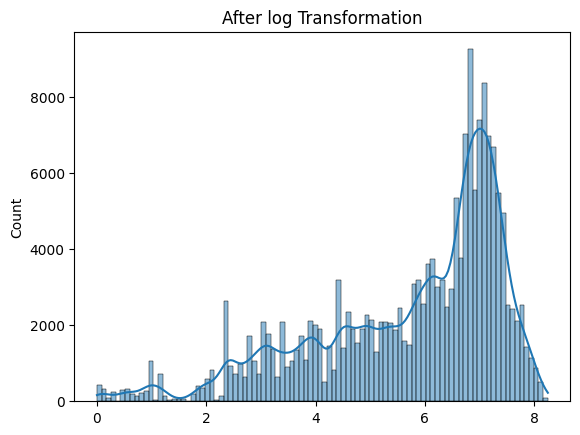

In [27]:
sns.histplot(x=X_train_transformed[:, 0], kde=True)
plt.title("After log Transformation")
plt.show()

In [28]:
preprocessor = ColumnTransformer(
    transformers=[
        ('rainfall_yeo', PowerTransformer(method='yeo-johnson', standardize=True), ['Rainfall'])
    ],
    remainder='passthrough' 
)

In [29]:
X_train_transformed = preprocessor.fit_transform(X_train)
X_test_transformed = preprocessor.transform(X_test)

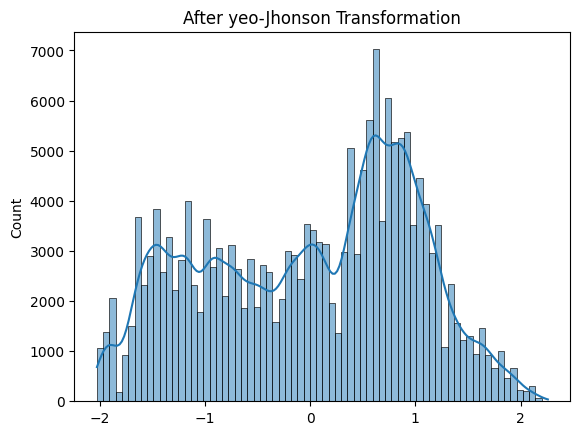

In [30]:
sns.histplot(x=X_train_transformed[:, 0], kde=True)
plt.title("After yeo-Jhonson Transformation")
plt.show()

In [31]:
X_train_t = preprocessor.fit_transform(X_train)
X_test_t  = preprocessor.transform(X_test)

models = {
    "Linear Regression": LinearRegression(),
    "Elastic Net": ElasticNet(alpha=1.0, l1_ratio=0.5),
    "Decision Tree": DecisionTreeRegressor(random_state=42),
    "Random Forest": RandomForestRegressor(n_estimators=100, n_jobs=-1, random_state=42),
    "XGBoost": XGBRegressor(n_estimators=100, learning_rate=0.1, n_jobs=-1, random_state=42)
}

results = {}

print(" Model Performance ")
print("-" * 30)

for name, model in models.items():
    model.fit(X_train_t, y_train)
    y_pred = model.predict(X_test_t)

    score = r2_score(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    rmse = root_mean_squared_error(y_test, y_pred)

    results[name] = score

    print(f"\nModel: {name}")
    print(f"R2 Score (Accuracy): {score:.4f}")
    print(f"Mean Absolute Error: {mae:.2f}")
    print(f"Root Mean Squared Error: {rmse:.2f}")

print("-" * 30)
best_model = max(results, key=results.get)
print(f"\n The Best Model is: {best_model} with Score: {results[best_model]:.4f}")


 Model Performance 
------------------------------

Model: Linear Regression
R2 Score (Accuracy): 0.1875
Mean Absolute Error: 69.24
Root Mean Squared Error: 626.25

Model: Elastic Net
R2 Score (Accuracy): 0.1835
Mean Absolute Error: 43.72
Root Mean Squared Error: 627.77

Model: Decision Tree
R2 Score (Accuracy): 0.8619
Mean Absolute Error: 11.63
Root Mean Squared Error: 258.22

Model: Random Forest
R2 Score (Accuracy): 0.9102
Mean Absolute Error: 9.65
Root Mean Squared Error: 208.20

Model: XGBoost
R2 Score (Accuracy): 0.8898
Mean Absolute Error: 13.72
Root Mean Squared Error: 230.60
------------------------------

 The Best Model is: Random Forest with Score: 0.9102


In [32]:
rf_model = RandomForestRegressor(
    n_estimators=200,
    max_depth=None,
    min_samples_split=2,
    min_samples_leaf=1,
    random_state=42,
    max_features = 'sqrt',
    n_jobs=-1
)

print("Training Random Forest Regressor...")
rf_model.fit(X_train_t, y_train)
print("Training Complete!")

y_train_pred = rf_model.predict(X_train_t)
y_test_pred  = rf_model.predict(X_test_t)

# 4. Evaluation
def evaluate_model(y_true, y_pred, label="Test"):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = root_mean_squared_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)

    print(f"\n--- {label} Set Performance ---")
    print(f"MAE:  {mae:.2f}")
    print(f"RMSE: {rmse:.2f}")
    print(f"R²:   {r2:.4f}")

evaluate_model(y_train, y_train_pred, "Train")
evaluate_model(y_test, y_test_pred, "Test")

Training Random Forest Regressor...
Training Complete!

--- Train Set Performance ---
MAE:  5.16
RMSE: 115.15
R²:   0.9816

--- Test Set Performance ---
MAE:  10.89
RMSE: 211.69
R²:   0.9072


In [33]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV

param_dist = {
    'n_estimators': [150, 200],
    'max_depth': [None, 10],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
    'max_features': ['sqrt']
}

rf_base = RandomForestRegressor(
    random_state=42,
    n_jobs=1          # 🔥 critical fix
)

rf_random_search = RandomizedSearchCV(
    estimator=rf_base,
    param_distributions=param_dist,
    n_iter=6,         # 🔥 reduced
    cv=3,             # 🔥 reduced
    scoring='r2',
    random_state=42,
    verbose=2,
    n_jobs=-1
)

print("Running Kaggle-safe RandomizedSearchCV...")
rf_random_search.fit(X_train_transformed, y_train)

print("\nBest Parameters:")
print(rf_random_search.best_params_)
print(f"Best CV R²: {rf_random_search.best_score_:.4f}")


Running Kaggle-safe RandomizedSearchCV...
Fitting 3 folds for each of 6 candidates, totalling 18 fits
[CV] END max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=150; total time= 1.3min
[CV] END max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=200; total time= 1.2min


/usr/local/lib/python3.12/dist-packages/joblib/externals/loky/process_executor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[CV] END max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time= 1.7min
[CV] END max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=200; total time= 1.2min

Best Parameters:
{'n_estimators': 200, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': None}
Best CV R²: 0.8923


In [34]:
from sklearn.model_selection import RandomizedSearchCV

param_dist = {
    'n_estimators': [200, 300, 400, 600],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [2, 3, 4, 5],
    'subsample': [0.7, 0.8, 1.0],
    'colsample_bytree': [0.7, 0.8, 1.0]
}

xgb_base = xgb.XGBRegressor(
    random_state=42,
    n_jobs=-1
)

random_search = RandomizedSearchCV(
    estimator=xgb_base,
    param_distributions=param_dist,
    n_iter=20,              
    cv=5,
    scoring='r2',
    verbose=1,
    random_state=42,
    n_jobs=-1
)

print("Running RandomizedSearchCV")
random_search.fit(X_train_transformed, y_train)

best_xgb = random_search.best_estimator_

print("Best Parameters:")
print(random_search.best_params_)


Running RandomizedSearchCV
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Best Parameters:
{'subsample': 0.7, 'n_estimators': 400, 'max_depth': 4, 'learning_rate': 0.1, 'colsample_bytree': 1.0}


In [35]:
y_train_pred_best = best_xgb.predict(X_train_transformed)
y_test_pred_best  = best_xgb.predict(X_test_transformed)

evaluate_model(y_train, y_train_pred_best, "Train (Tuned)")
evaluate_model(y_test, y_test_pred_best, "Test (Tuned)")



--- Train (Tuned) Set Performance ---
MAE:  13.34
RMSE: 202.96
R²:   0.9427

--- Test (Tuned) Set Performance ---
MAE:  15.06
RMSE: 237.69
R²:   0.8830


In [36]:
xgb_model = xgb.XGBRegressor(
    n_estimators=400,
    learning_rate=0.1,
    max_depth=3,
    random_state=42,
    colsample_bytree = 1.0,
    n_jobs=-1  
)

print("Training XGBoost Model")
xgb_model.fit(X_train_transformed, y_train)
print("Training Complete!")

y_train_pred = xgb_model.predict(X_train_transformed)
y_test_pred = xgb_model.predict(X_test_transformed)

def evaluate_model(y_true, y_pred, set_name="Test"):
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_true, y_pred)
    
    print(f"--- {set_name} Set Performance")
    print(f"MAE:  {mae:.4f}")
    print(f"RMSE: {rmse:.4f}")
    print(f"learning rate: {xgb_model.learning_rate}")
    print(f"R2 Score: {r2:.4f}")
    print("-" * 30)

evaluate_model(y_train, y_train_pred, "Train")
evaluate_model(y_test, y_test_pred, "Test")

Training XGBoost Model
Training Complete!
--- Train Set Performance
MAE:  17.9692
RMSE: 256.2169
learning rate: 0.1
R2 Score: 0.9087
------------------------------
--- Test Set Performance
MAE:  16.9830
RMSE: 230.2500
learning rate: 0.1
R2 Score: 0.8902
------------------------------
